# Model 16
## model 8 add epoch 20

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_borusan=pd.read_csv(r"C:\Users\denem\Downloads\BorsnTav4BrulorAtikGz.csv")

In [3]:
df_borusan.head()

,time,xVRMS,yVRMS,zVRMS,temp,cf,maxCf
0,2022-08-25 12:55:00,0.0,0.0000,0.0000,31.51934,2.77160,NaN
1,2022-08-25 13:00:00,0.0,0.0000,0.0000,31.68508,2.37825,NaN
2,2022-08-25 13:05:00,0.0,0.0000,0.0000,31.40884,2.43790,NaN
3,2022-08-25 13:10:00,0.0,0.0942,0.0000,31.29834,2.95775,NaN
4,2022-08-25 13:15:00,0.0,0.0000,0.1332,31.13260,2.56905,NaN


In [4]:
new_df_brs=df_borusan.sort_values("time")

In [5]:
df2_x=new_df_brs["xVRMS"]

In [6]:
df2_x.isnull().sum()

1

In [7]:
df2_x=df2_x.fillna(df2_x.mean())

In [8]:
df2_x.isnull().sum()

0

In [9]:
df2_x.index = pd.to_datetime(new_df_brs["time"])

In [10]:
df2_x.tail()

time
2023-04-16 21:30:00    0.09274
2023-04-16 21:35:00    0.07039
2023-04-16 21:40:00    0.05755
2023-04-16 21:45:00    0.06973
2023-04-16 21:50:00    0.10341
Name: xVRMS, dtype: float64

In [11]:
len(df2_x)

60134

In [12]:
def clean_limit(df_column, low_limit, up_limit=None):
    if up_limit is None:
        filtered = df_column[(df_column >= low_limit)]
        
    else:
        filtered = df_column.loc[(df_column >= low_limit) & (df_column <= up_limit)]
    return filtered

In [13]:
df2_x=clean_limit(df2_x,low_limit=1)

In [14]:
len(df2_x)

35609

## 3 sigma

In [15]:
process_clm = df2_x
process_clm_mean = process_clm.mean()
process_clm_std = process_clm.std()

up_limit = process_clm_mean + 2 * process_clm_std
low_limit = process_clm_mean - 2 * process_clm_std

process_clm_mean,process_clm_std,up_limit,low_limit

(3.0141387025698116,
 0.40044119446333715,
 3.8150210914964857,
 2.2132563136431376)

In [16]:
df2_x=clean_limit(df2_x,low_limit=low_limit,up_limit=up_limit)

In [17]:
len(df2_x)

34497

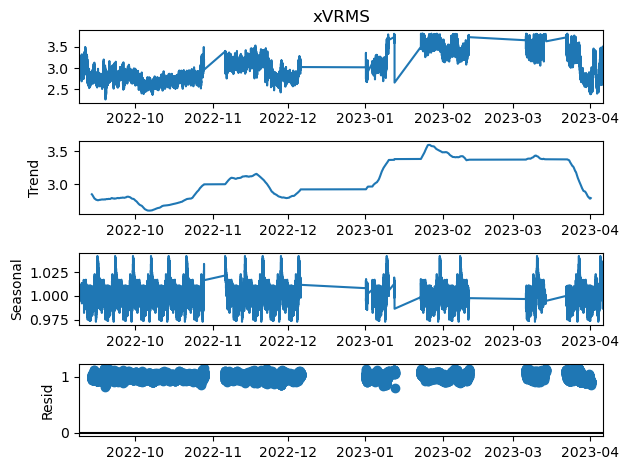

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2_x, model='multiplicative',period=2036)
result.plot()
plt.show()

In [19]:
def df_to_X_y(df, window_size=5):
  """
  Converts a pandas DataFrame to a tuple of NumPy arrays, where X is the input data and y is the target data.

  Args:
    df: A pandas DataFrame.
    window_size: The size of the sliding window.

  Returns:
    A tuple of NumPy arrays, where X is the input data and y is the target data.
  """

  # Convert the DataFrame to a NumPy array.
  df_as_np = df.to_numpy()

  # Create the input and target data.
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = df_as_np[i:i + window_size]
    X.append(row)
    label = df_as_np[i + window_size]
    y.append(label)

  # Return the input and target data as NumPy arrays.
  return np.array(X), np.array(y)

In [20]:
WINDOW_SIZE=10

In [21]:
X,y =df_to_X_y(df2_x,WINDOW_SIZE)
X.shape,y.shape

((34487, 10), (34487,))

In [22]:
total_size = len(X)
train_size = int(total_size * 0.8)
val_size = int(total_size * 0.1)

X_train, y_train = X[:train_size], y[:train_size]  # %80
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]  # %10
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]  # %10

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((27589, 10), (27589,), (3448, 10), (3448,), (3450, 10), (3450,))

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [24]:
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping

# Assuming X_train, X_val, and X_test are your input features
# Assuming y_train, y_val, and y_test are your target variables

# Create a MinMaxScaler object for the input features
scaler = MinMaxScaler()

# Fit the scaler on the training input features
scaler.fit(X_train)

# Apply normalization to the input features
X_train_normalized = scaler.transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

# Rest of your code
model16 = Sequential()
model16.add(InputLayer((WINDOW_SIZE, 1)))
model16.add(LSTM(128, return_sequences=True))
model16.add(LSTM(64))
model16.add(Dropout(0.2))
model16.add(Dense(8, activation='relu'))
model16.add(Dense(1, activation='linear'))

# Compile the model
model16.compile(loss='mean_squared_error', optimizer='adam')

# Apply early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model using the normalized input features and target variables
model16.fit(X_train_normalized, y_train, epochs=20, validation_data=(X_val_normalized, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = model16.evaluate(X_test_normalized, y_test)

# Make predictions using the test set
#y_pred = model16.predict(X_test_normalized)

# Perform any necessary inverse transformations on the predictions or further analysis

Epoch 1/20
863/863 [==============================] - 10s 9ms/step - loss: 0.1495 - val_loss: 0.0135
Epoch 2/20
863/863 [==============================] - 7s 8ms/step - loss: 0.0350 - val_loss: 0.0093
Epoch 3/20
863/863 [==============================] - 8s 9ms/step - loss: 0.0301 - val_loss: 0.0098
Epoch 4/20
863/863 [==============================] - 7s 8ms/step - loss: 0.0248 - val_loss: 0.0090
Epoch 5/20
863/863 [==============================] - 7s 8ms/step - loss: 0.0185 - val_loss: 0.0260
Epoch 6/20
863/863 [==============================] - 8s 9ms/step - loss: 0.0122 - val_loss: 0.0135
Epoch 7/20
863/863 [==============================] - 8s 10ms/step - loss: 0.0079 - val_loss: 0.0161
Epoch 8/20
863/863 [==============================] - 7s 8ms/step - loss: 0.0060 - val_loss: 0.0113
Epoch 9/20
863/863 [==============================] - 7s 8ms/step - loss: 0.0051 - val_loss: 0.0095
Epoch 10/20
863/863 [==============================] - 6s 7ms/step - loss: 0.0047 - val_loss: 0.01

In [25]:
train_predictions = model16.predict(X_train_normalized).flatten()
train_results = pd.DataFrame(data={"Train Predictions": train_predictions, "Actuals": y_train.flatten()})
train_results

863/863 [==============================] - 2s 2ms/step


,Train Predictions,Actuals
0,3.034181,2.93636
1,3.020856,2.96868
2,3.016546,3.05065
3,3.017397,3.07892
4,3.025406,3.09550
...,...,...
27584,3.473222,3.46797
27585,3.472661,3.59522
27586,3.488038,3.57622
27587,3.501624,3.49203


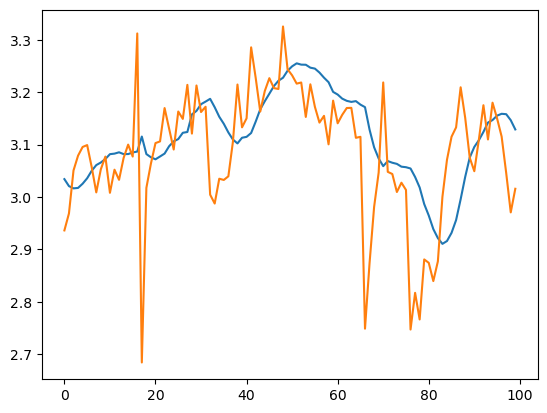

In [26]:
plt.plot(train_results["Train Predictions"][:100])
plt.plot(train_results["Actuals"][:100])

In [27]:
val_predictions=model16.predict(X_val_normalized).flatten()
val_results=pd.DataFrame(data={"Validation Predictions": val_predictions,"Actuals":y_val.flatten()})
val_results

108/108 [==============================] - 0s 2ms/step


,Validation Predictions,Actuals
0,3.511239,3.51940
1,3.519010,3.62920
2,3.536587,3.67474
3,3.558780,3.52756
4,3.571047,3.68832
...,...,...
3443,3.566510,3.36224
3444,3.553918,3.57633
3445,3.567443,3.47285
3446,3.558668,3.52758


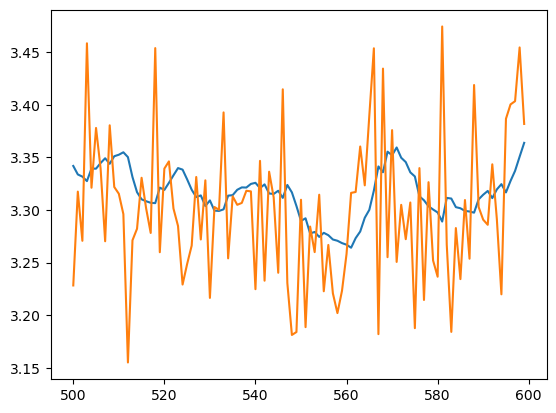

In [28]:
plt.plot(val_results["Validation Predictions"][500:600])
plt.plot(val_results["Actuals"][500:600])

In [104]:
test_predictions=model16.predict(X_test_normalized).flatten()
test_results=pd.DataFrame(data={"Test Predictions": test_predictions,"Actuals":y_test.flatten()})
test_results

108/108 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,3.538198,3.61257
1,3.544773,3.64126
2,3.546686,3.48754
3,3.535947,3.42785
4,3.530985,3.58766
...,...,...
3445,3.314273,3.15416
3446,3.289659,3.15994
3447,3.264843,3.13281
3448,3.241329,3.05874


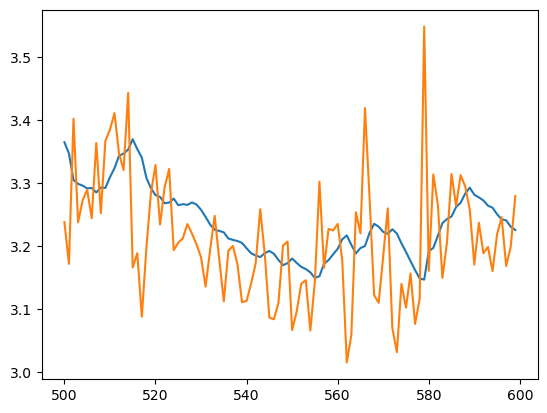

In [106]:
plt.plot(test_results["Test Predictions"][500:600])
plt.plot(test_results["Actuals"][500:600])

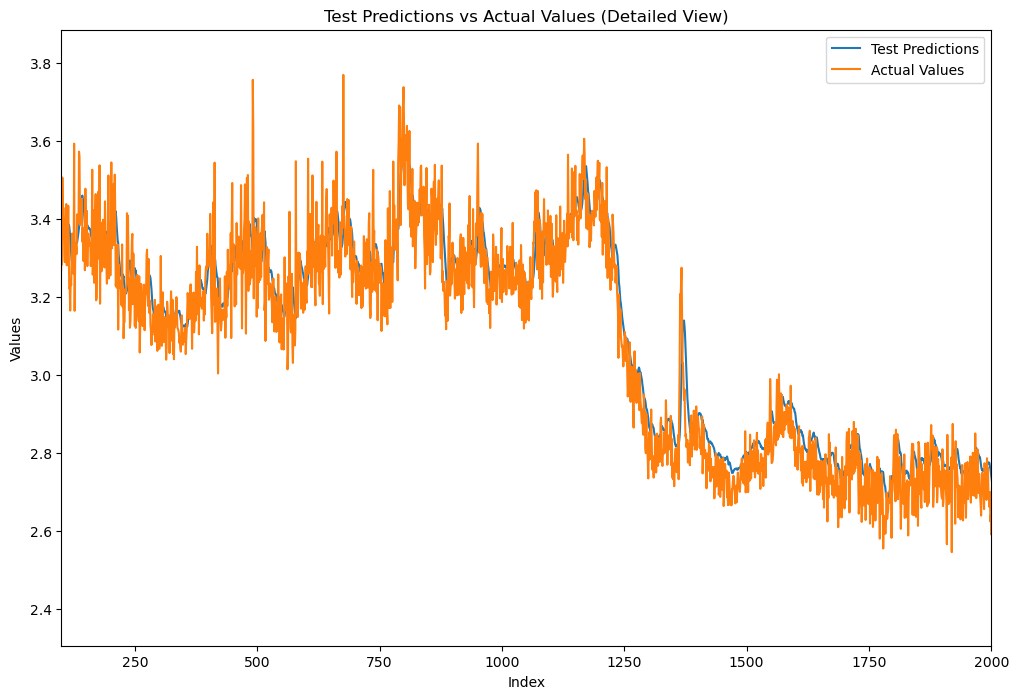

In [115]:
import matplotlib.pyplot as plt

# Assuming you have the test predictions and actual values stored in the 'test_results' DataFrame

# Get the test predictions and actual values from the DataFrame
test_predictions = test_results["Test Predictions"]
actuals = test_results["Actuals"]

# Plotting the trend graph with more detail
plt.figure(figsize=(12, 8))
plt.plot(test_predictions, label='Test Predictions',)
plt.plot(actuals, label='Actual Values',)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Test Predictions vs Actual Values (Detailed View)')
plt.legend()

# Customize the x-axis range for a specific section of the data
start_index = 100  # Specify the starting index of the desired section
end_index = 2000    # Specify the ending index of the desired section
plt.xlim(start_index, end_index)

# Customize the y-axis range if needed
# plt.ylim(min_value, max_value)  # Specify the desired minimum and maximum values for the y-axis

plt.show()


In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Modelin tahminlerini alın
y_train_pred = train_predictions
y_val_pred = val_predictions
y_test_pred = test_predictions

# Regresyon metrikleri

# Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Root Mean Squared Error (RMSE)
rmse_train = np.sqrt(mse_train)
rmse_val = np.sqrt(mse_val)
rmse_test = np.sqrt(mse_test)

# R Squared (R^2) Score
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# Sonuçları yazdırma
print("Regression Metrics:")
print("MAE - Train:", mae_train)
print("MAE - Validation:", mae_val)
print("MAE - Test:", mae_test)
print("MSE - Train:", mse_train)
print("MSE - Validation:", mse_val)
print("MSE - Test:", mse_test)
print("RMSE - Train:", rmse_train)
print("RMSE - Validation:", rmse_val)
print("RMSE - Test:", rmse_test)
print("R^2 Score - Train:", r2_train)
print("R^2 Score - Validation:", r2_val)
print("R^2 Score - Test:", r2_test)



Regression Metrics:
MAE - Train: 0.0614941890197547
MAE - Validation: 0.07312093710892716
MAE - Test: 0.07128319919095247
MSE - Train: 0.006023292840869951
MSE - Validation: 0.00901172566769994
MSE - Test: 0.008436985836493069
RMSE - Train: 0.07760987592355725
RMSE - Validation: 0.09493010938421982
RMSE - Test: 0.09185306656009405
R^2 Score - Train: 0.9310573459184656
R^2 Score - Validation: 0.6119260014400596
R^2 Score - Test: 0.9124269990003566


# Doing Forcesting

In [41]:
df=pd.DataFrame(df2_x)

In [45]:
df=df.reset_index(drop=False)

In [46]:
df.head()

,time,xVRMS
0,2022-09-08 11:35:00,3.08985
1,2022-09-08 11:40:00,2.96818
2,2022-09-08 11:45:00,3.06848
3,2022-09-08 11:50:00,3.02814
4,2022-09-08 11:55:00,3.06044


In [49]:
df2_x.head()

time
2022-09-08 11:35:00    3.08985
2022-09-08 11:40:00    2.96818
2022-09-08 11:45:00    3.06848
2022-09-08 11:50:00    3.02814
2022-09-08 11:55:00    3.06044
Name: xVRMS, dtype: float64

In [58]:
model16.output_shape

(None, 1)

In [59]:
X_train_normalized.shape

(27589, 10)

In [102]:
y_test[:10]

array([3.61257, 3.64126, 3.48754, 3.42785, 3.58766, 3.49448, 3.52166,
       3.59625, 3.48912, 3.43719])

In [103]:
X_test[:10]

array([[3.48845, 3.73471, 3.73221, 3.42075, 3.67087, 3.36224, 3.57633,
        3.47285, 3.52758, 3.44338],
       [3.73471, 3.73221, 3.42075, 3.67087, 3.36224, 3.57633, 3.47285,
        3.52758, 3.44338, 3.61257],
       [3.73221, 3.42075, 3.67087, 3.36224, 3.57633, 3.47285, 3.52758,
        3.44338, 3.61257, 3.64126],
       [3.42075, 3.67087, 3.36224, 3.57633, 3.47285, 3.52758, 3.44338,
        3.61257, 3.64126, 3.48754],
       [3.67087, 3.36224, 3.57633, 3.47285, 3.52758, 3.44338, 3.61257,
        3.64126, 3.48754, 3.42785],
       [3.36224, 3.57633, 3.47285, 3.52758, 3.44338, 3.61257, 3.64126,
        3.48754, 3.42785, 3.58766],
       [3.57633, 3.47285, 3.52758, 3.44338, 3.61257, 3.64126, 3.48754,
        3.42785, 3.58766, 3.49448],
       [3.47285, 3.52758, 3.44338, 3.61257, 3.64126, 3.48754, 3.42785,
        3.58766, 3.49448, 3.52166],
       [3.52758, 3.44338, 3.61257, 3.64126, 3.48754, 3.42785, 3.58766,
        3.49448, 3.52166, 3.59625],
       [3.44338, 3.61257, 3.64126, 3.

In [86]:
close_data = df2_x.values
close_data = close_data.reshape((-1))
look_back = 10


def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['time'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 100
forecast = predict(num_prediction, model16)
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 13ms/step


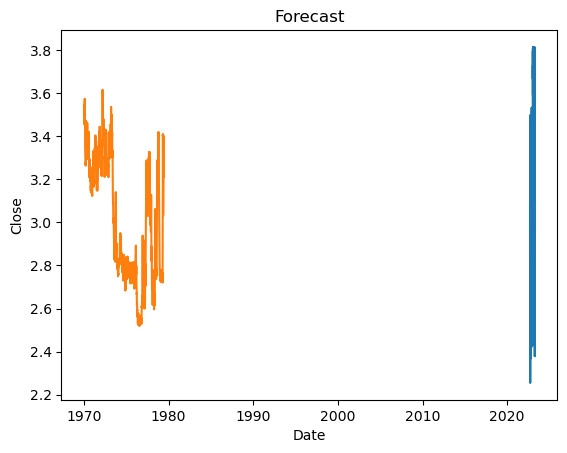

In [95]:
import matplotlib.pyplot as plt

# Plot the actual values
plt.plot(df2_x)

# Plot the forecast
plt.plot(y_test_pred)

# Add a title and labels
plt.title("Forecast")
plt.xlabel("Date")
plt.ylabel("Close")

# Show the plot
plt.show()


In [63]:
import pandas as pd
import numpy as np

# Load the test data
test_data = df

# Get the last date of the test data
last_date = test_data.iloc[-1]["time"]

# Create a new dataframe with the last date of the test data as the first row
next_week_data = pd.DataFrame({"time": [last_date]})

# Fill the rest of the rows with NaN values
next_week_data = next_week_data.fillna(np.nan)

# Use the model to predict the values for the next week
for i in range(60 * 24):
    next_week_data["Predictions"] = model16.predict(next_week_data.values.reshape((1, 10, 1)))

# Print the dataframe
print(next_week_data)


ValueError: cannot reshape array of size 1 into shape (1,10,1)

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already trained your model and have the necessary data

# Preprocess the forecast data
# Assuming you have your forecast data stored in a variable called 'X_forecast_normalized'
# Ensure that it has the same shape as your training data
#X_forecast_normalized.shape = (number_of_samples, number_of_features)

# Reshape the forecast data to match the expected input shape of the model
X_forecast_normalized=X_test_normalized
X_forecast_normalized = np.reshape(X_forecast_normalized, (X_forecast_normalized.shape[0], 1, X_forecast_normalized.shape[1]))

# Generate predictions for the forecast data using your trained model
predictions = model16.predict(X_forecast_normalized)

# Reshape the predictions if necessary
predictions = predictions.reshape(-1)  # Assuming predictions.shape = (number_of_samples, 1)

# Plotting the graph
plt.figure(figsize=(10, 6))
# Assuming you have a variable called 'existing_test_data' containing the existing test data
plt.plot(existing_test_data, label='Existing Test Data')
plt.plot(predictions, label='Forecasted Data')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Forecasted Data vs Existing Test Data')
plt.legend()
plt.show()


TypeError: in user code:

    File "C:\Users\denem\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\denem\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\denem\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\denem\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\denem\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\denem\anaconda3\lib\site-packages\keras\layers\rnn\lstm.py", line 615, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [139]:
# Create a list of dates and times
dates = pd.date_range("2023-04-16 21:50:00", periods=2880, freq="5T")

# Create a DataFrame with the dates and times as the index and the values as 0
df_frcst = pd.DataFrame(index=dates, columns=["Value"])

In [140]:
df_frcst.head()

,Value
2023-04-16 21:50:00,NaN
2023-04-16 21:55:00,NaN
2023-04-16 22:00:00,NaN
2023-04-16 22:05:00,NaN
2023-04-16 22:10:00,NaN


In [156]:
import random
for i in range(len(df_frcst)):
    df_frcst.iloc[i] = random.uniform(0, 6)

In [157]:
df_frcst.head()

,Value
2023-04-16 21:50:00,1.485414
2023-04-16 21:55:00,4.254639
2023-04-16 22:00:00,0.884950
2023-04-16 22:05:00,4.253270
2023-04-16 22:10:00,5.236223


In [158]:
len(df_frcst)

5762

In [159]:
df_frcst_v=df_frcst["Value"]

In [160]:
X,y=df_to_X_y(df_frcst_v)

In [161]:
X.shape,y.shape

((5757, 5), (5757,))

In [162]:
test_predictions=model16.predict(X).flatten()
test_results=pd.DataFrame(data={"Test Predictions": test_predictions,"Actuals":y.flatten()})
test_results

180/180 [==============================] - 1s 2ms/step


,Test Predictions,Actuals
0,4.941269,5.835361
1,5.315061,5.094126
2,5.393785,1.622578
3,5.295782,2.773699
4,5.215337,2.598575
...,...,...
5752,5.405289,2.534376
5753,5.234700,1.120446
5754,4.937943,1.072575
5755,4.637087,3.575763


AttributeError: module 'matplotlib.pyplot' has no attribute 'label'

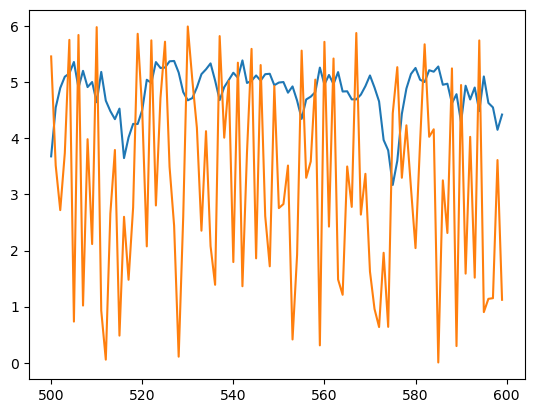

In [164]:
plt.plot(test_results["Test Predictions"][500:600])
plt.plot(test_results["Actuals"][500:600])


